In [7]:
# Setup the environment first

# read: https://github.com/mirnylab/cooler/issues/138 for more details:

# !export MKL_NUM_THREADS=1 - # not working in a notebook ((
# instead do this, after making sure mkl is installed
import mkl
mkl.set_num_threads(1)



In [3]:
# are you developing?
# turn module reloading on

# %load_ext autoreload
# %autoreload 2

In [4]:
# neccessary modules to be imported

import os.path as op
from scipy.stats import poisson
import pandas as pd
import numpy as np
import cooler

from cooltools import dotfinder

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker

In [55]:
# input files to play with
# pick Rao et al primary @10kb to enable comparison

# what I have here is Rao et al 2014 sample for GM cells
# the dataset that they refer to as "primary" in the paper
# the cooler created using hic2cool tool
# and what I have here is an older version before divisive/multiplicative
# balancing weights situation happened
path = "/home/venevs/DOTS_TESTING/prim_rep_rao_Mar19"
basename = "GM12878_insitu_primary_30.KR"

# this is a 10kb cooler file
# and we should also have expected calculated for 10kb

COOL10="{}/{}.cool".format(path,basename)
EXP10="{}/{}.cis.expected".format(path,basename)

LOOP10="{}/cloops_{}.bedpe".format(path,basename)
# # HDF10=test_scores$TESTIDX\_$BASENAME.10000.hdf
FLOOP10="{}/cloops_{}.bedpe.postprocess".format(path,basename)

RAOLOOPS="/home/venevs/DOTS_TESTING/rao_combined_hic/Rao2014_GM12878_primary_and_replicate_HiCCUPS_looplist.txt"
RAOLOOPS="/home/venevs/DOTS_TESTING/prim_rep_rao/Rao2014_GM12878_primary_HiCCUPS_looplist.txt"

# keeping some of the relevant CLI commands here
# useful for preprocessing cooler files - before calling dots

# 0. consider adding downloading command for Rao data e.g.
# 0. also condsider showing hic2cool usage here to turn .hic to .cool

# 1. re-balancing - cis-only is worth checking out at the very least ...
# cooler balance -p {threads} --ignore-diags 1 --force --name 'wsnake' {input}::/resolutions/{res}

# 2. calculation of expected
# cooltools compute-expected -p {threads} --weight-name 'wsnake' --drop-diags 1 {input[0]}::/resolutions/{res}


### provide arguments to replace CLI interface

instead of providing comman line arguments to the `call-dots` tool we are going to provide corresponding argumnets right in the notebook:

In [9]:
# specify parameters for call-dots
cool_path = COOL10
expected_path = EXP10
expected_name = 'balanced.avg'
nproc = 8
max_loci_separation = 1000000
max_nans_tolerated = 4
tile_size = 10000000
fdr = 0.1
dots_clustering_radius = 21000
verbose = True
balancing_weight_name = "weight"
output_scores = 'xxx'
output_hists = 'yyy'
output_calls = 'zzz'
score_dump_mode = 'parquet'
# score_dump_mode = 'local'
temp_dir = './'
no_delete_temp = True

### load cooler and expected

In [10]:
clr = cooler.Cooler(cool_path)

expected_columns = ['chrom', 'diag', 'n_valid', expected_name]
expected_index = ['chrom', 'diag']
expected_dtypes = {
    'chrom': np.str,
    'diag': np.int64,
    'n_valid': np.int64,
    expected_name: np.float64
}
expected = pd.read_table(
    expected_path,
    usecols=expected_columns,
    index_col=expected_index,
    dtype=expected_dtypes,
    comment=None,
    verbose=verbose)
# include Geoff's fix for the datatypes in expected

Tokenization took: 47.45 ms
Type conversion took: 19.71 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 31.80 ms
Type conversion took: 18.99 ms
Parser memory cleanup took: 0.01 ms
Tokenization took: 9.56 ms
Type conversion took: 5.91 ms
Parser memory cleanup took: 0.00 ms


### we'll do everyhting for `chr1` only to save time (reconsider it later ...)

demonstration purposes only this way ...

In [11]:
# beware of chromosome naming converntion, i.e. "chr1" vs "1" ...
expected = expected.loc[["1"]]

### some validation
Just making sure that expected anb cooler are "compatible"
i.e. they refer to the same chromosomes and those chromosomes have the same length

In [12]:
# Input validation
# unique list of chroms mentioned in expected_path
# do simple column-name validation for now
get_exp_chroms = lambda df: df.index.get_level_values("chrom").unique()
expected_chroms = get_exp_chroms(expected)
if not set(expected_chroms).issubset(clr.chromnames):
    raise ValueError(
        "Chromosomes in {} must be subset of ".format(expected_path) +
        "chromosomes in cooler {}".format(cool_path))
# check number of bins
# compute # of bins by comparing matching indexes
get_exp_bins = lambda df, ref_chroms: (
    df.index.get_level_values("chrom").isin(ref_chroms).sum())
expected_bins = get_exp_bins(expected, expected_chroms)
cool_bins = clr.bins()[:]["chrom"].isin(expected_chroms).sum()
if not (expected_bins == cool_bins):
    raise ValueError(
        "Number of bins is not matching: ",
        "{} in {}, and {} in {} for chromosomes {}".format(
            expected_bins,
            expected_path,
            cool_bins,
            cool_path,
            expected_chroms))
if verbose:
    print("{} and {} passed cross-compatibility checks.".format(
        cool_path, expected_path))

/home/venevs/DOTS_TESTING/prim_rep_rao_Mar19/GM12878_insitu_primary_30.KR.cool and /home/venevs/DOTS_TESTING/prim_rep_rao_Mar19/GM12878_insitu_primary_30.KR.cis.expected passed cross-compatibility checks.


### prepare some other parameters 

In [13]:
# Prepare some parameters.
binsize = clr.binsize
loci_separation_bins = int(max_loci_separation / binsize)
tile_size_bins = int(tile_size / binsize)
balance_factor = 1.0  #clr._load_attrs("bins/weight")["scale"]

print("we are dealing with the data binned at {}".format(binsize))

# clustering would deal with bases-units for now, so supress this for now
# clustering_radius_bins = int(dots_clustering_radius/binsize)

# pre-defined kernel types that are going to be used in the analysis
ktypes = ['donut', 'vertical', 'horizontal', 'lowleft']

we are dealing with the data binned at 10000


### choosing w and p for the kernel sizes
we should replace it or hide it with the function that "recommends" `w` and `p` based on the `binsize`
but also we should provide a CLI interface for changing those at will ...

or should we "read" kernel-footprints from a separate file ... for ultimate customizability ?!

In [14]:
w,p = dotfinder.recommend_kernel_params(binsize)
print("Kernel parameters w={} p={}".format(w,p))

Kernel parameters w=5 p=2


In [15]:
kernels = {k: dotfinder.get_kernel(w, p, k) for k in ktypes}

# list of tile coordinate ranges
tiles = list(
    dotfinder.heatmap_tiles_generator_diag(
        clr,
        expected_chroms,
        w,
        tile_size_bins,
        loci_separation_bins
    )
)   

[Text(1, 0, 'Excluded from calculation'),
 Text(1, 0, 'Included in calculations')]

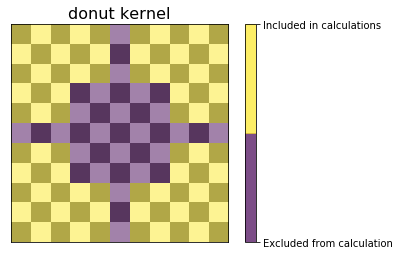

In [16]:
# it is important to demonstrate filters here 
# consider moving plotting code elsewhere or simplify it significantly ...
# split cell above and demonstrate kernels - it's nice:

ktype='donut'
kernel= kernels[ktype]
y,x = np.ogrid[-w:w+1, -w:w+1]

extent = (0-0.5,
          x.size-0.5,
          0-0.5,
          y.size-0.5)
########################
plt.clf()
# axes setup
ax = plt.gca()
# discrete colormap with 2 colors ...
cmap = colors.ListedColormap([plt.cm.viridis(0),
                              plt.cm.viridis(1.0)])
# kernel:
imk = ax.imshow(kernel,
                alpha=0.7,
                cmap=cmap,
                extent=extent,
                interpolation='nearest')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels('',visible=False)
ax.set_yticklabels('',visible=False)
ax.set_title("{} kernel".format(ktype),fontsize=16)

# add checkerboard to depict pixels:
checkerboard = np.add.outer(range(x.size),
                            range(y.size)) % 2
ax.imshow(checkerboard,
        cmap=plt.cm.gray,
        interpolation='nearest',
        extent=extent,
        alpha=0.3)
#####################
# colorbar and that's it:
cb = plt.colorbar(imk)
cb.ax.get_yaxis().set_major_locator(ticker.MaxNLocator(1))
cb.ax.set_yticklabels(['Excluded from calculation','Included in calculations'])

### Getting to the calculations of locally-adjusted expected

 - for demonstration and debugging purposes we are going to dump the dataframe with locally adjusted expected right in place (i.e. in memory).
 - This might be also ok for smaller genomes and potentially for small subsets of large genomes.
 - This is not recommended whatsoever for genome-wide dot-calling.

A side note, we've tried to store all of the values in a separate file,
but practice shows that for large genomes even parquet/hdf5 are not fast enough.
Thus using a **2-pass** strategy seems to be the best option indeed.

**2-pass**: calculate locally-adjusted expected for each pixel and use this value *immediately* to build a hitogram with predefined bins, then recalculate locally-adjusted expected values and again use them *in place* to select significantly enriched pixels.


 - an example on how to store locally adjusted expected in a temporary file:
```python
import tempfile
tmp_scores = tempfile.NamedTemporaryFile(
    suffix='.parquet',
    delete= False,
    dir='.')
```
 - now calculate locally adjusted expected:
```python
loc_adj_exp = dotfinder.scoring_step(clr,
                    expected,
                    expected_name,
                    "weight",
                    tiles,
                    kernels,
                    max_nans_tolerated,
                    loci_separation_bins,
                    tmp_scores,
                    nproc,
                    score_dump_mode,
                    verbose)
```
 - histogramming using temporary input:
```python
gw_hist = dotfinder.histogramming_step(tmp_scores,
                                    score_dump_mode,
                                    kernels,
                                    ledges,
                                    output_path=None,
                                    nproc=1,
                                    verbose=False)
```

In [17]:
# locally adjusted returned in place for just 1 chromosome:
la_exp = dotfinder.scoring_step(clr,
                    expected,
                    expected_name,
                    balancing_weight_name,
                    tiles,
                    kernels,
                    1,
                    loci_separation_bins,
                    None,
                    nproc,
                    "local",
                    verbose)

Preparing to convolve 49 tiles:
creating a Pool of 8 workers to tackle 49 tiles
returning local copy of the dataframe ...


### that is how locally adjusted expected dataframe looks like:

bin1_id|bin2_id|count|la_exp.donut.value|la_exp.vertical.value|la_exp.horizontal.value|la_exp.lowleft.value
---|---|---|---|---|---|---
76|87|20|16.343724585366036|19.112339277607475|14.789222300465001|17.55971648783403
76|88|29|21.109446293886823|23.76004284738352|19.119195822013385|23.30209962326733
76|89|15|17.254427190306977|18.545853810657224|14.695003640984938|19.784933947834944
76|90|21|14.277047600786759|14.642767228999286|12.928217571836717|17.27371365389384
76|91|13|11.22588212884422|11.279966641429564|10.064704945467405|14.514049136987758

 - here we use `cooler`-based `bin1/2_id` instead of actual genomic coordinates for compactness and performance reasons.
 - Observed is recorded in the `count` columns, again as in the parent `cooler`-file.
 - observer and all types of expected are expressed in the raw units in order to apply Poisson statistics to the data


### Now let's load in, some known called/annotated dots to see where they end up on the obs/exp scatter-plot

In [140]:
# let us read in some of the known dots to display stronger ones on the obs/exp scatter plot:
raodots = pd.read_csv(RAOLOOPS,sep='\t')
# beware of the UCSC/NCBI chromosome naming conventions `X` vs `chrX` ...
raodots_chr1 = raodots[raodots['chr1']=='1']

# do we need a notion of strength here ?
# #let's quickly define some measure of strengths for the dots:
# raodots_chr1['strength'] = raodots_chr1['o']/raodots_chr1['e_donut']
# # now sort and select only the strongest (according to this measure):
# raodots_chr1_strong = raodots_chr1.sort_values(by=['o','strength'],ascending=False)

# let's convert genomic coordinates into `cooler`-based bin_id-s:
bin1_ids = (raodots_chr1['x1']/binsize).astype('int')
bin2_ids = (raodots_chr1['y1']/binsize).astype('int')
# beware Rao et al, use x1,x2 for start1,end1 and y1,y2 for start2,end2

# now let's look up these called/annotated dots in our pre-calculated la_exp dataframe:
rao_dots_idxs = list(zip(bin1_ids,bin2_ids))
la_exp_indexed = la_exp.set_index(['bin1_id','bin2_id'])

# these are the rao-dots that we have caculated locally adjusted expected for:
intersect_raodots = la_exp_indexed[la_exp_indexed.index.isin(rao_dots_idxs)]
# we don't have for every rao-dot since we don't get close enough to diagonal and
# potentially treat NaNs differently.

### obs/exp scatter

 - let's plot a scatter of obs/exp for a subsample of surveyed pixels
 - highlight called rao-dots on this scatter plot
 - we need subsampling because there are a LOT of pixels

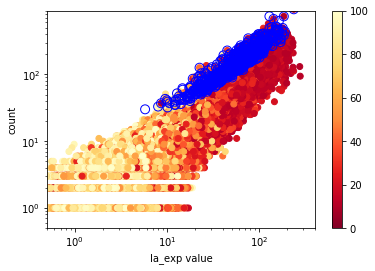

In [130]:
xlabel = 'la_exp.donut.value'
ylabel = 'count'

# we might consider "downsampling" la_exp dataframe in order to make obs/exp scatter plot less busy:
sub_la_exp = la_exp.sample(frac=0.7)

sct = plt.scatter(sub_la_exp[xlabel],
                  sub_la_exp[ylabel],
                  # color dots on the scatter by their genomic separation
                  c=sub_la_exp['bin2_id']-sub_la_exp['bin1_id'],
                  vmin=0,
                  vmax = 100,
                  cmap="YlOrRd_r")



plt.scatter(yyy[xlabel],yyy[ylabel], s=80, facecolors='none', edgecolors='b')
# plt.scatter(eeee[xlabel],eeee[ylabel], s=80, facecolors='none', edgecolors='y')



# plt.vlines(ledges[1:-15],ymin=0.5,ymax=900,color='red')

ax = plt.gca()
fig = plt.gcf()

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(0.5,400)
ax.set_ylim(0.5,900)

ax.set_ylabel("count")
ax.set_xlabel("la_exp value")

fig.colorbar(scat)

In [98]:
2**0.3333333333333333333333333333333333333333333333333333333333333

1.2599210498948732

In [67]:
cccc[(cccc['bin2_id']-cccc['bin1_id']<15)&(cccc[xlabel]<5)]

,bin1_id,bin2_id,count,la_exp.donut.value,la_exp.vertical.value,la_exp.horizontal.value,la_exp.lowleft.value
45527,2551,2565,1,2.943875,3.369522,2.539612,2.749783
45615,2552,2565,4,4.808669,6.340658,4.130355,4.223058
45703,2553,2565,3,4.977163,6.820646,4.021224,4.243577
46236,2559,2570,6,4.140280,2.644104,5.273157,3.869909
46238,2559,2572,3,3.191047,2.262594,3.784151,2.541656
46239,2559,2573,0,3.295056,2.360885,3.822843,2.604651
46326,2560,2572,3,3.528551,2.261038,3.835793,2.749389
46327,2560,2573,0,3.692040,2.392316,4.023391,2.799043
46328,2560,2574,7,3.171775,2.801629,3.776033,2.344038
46503,2562,2573,5,4.353290,3.743578,3.789606,3.972032


Text(0, 0.5, 'la_exp value')

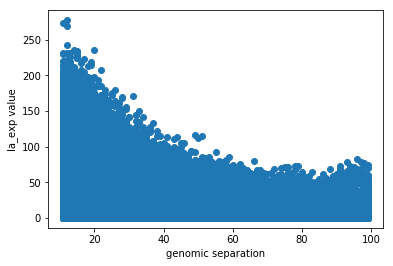

In [89]:
xlabel = 'la_exp.donut.value'
ylabel = 'count'

plt.scatter(cccc['bin2_id']-cccc['bin1_id'],(cccc[xlabel]))
# plt.scatter(dddd[xlabel],dddd[ylabel], s=80, facecolors='none', edgecolors='r')
# plt.scatter(eeee[xlabel],eeee[ylabel], s=80, facecolors='none', edgecolors='y')

ax = plt.gca()

ax.set_xlabel("genomic separation")
ax.set_ylabel("la_exp value")


Text(0.5, 0, '# of interactions')

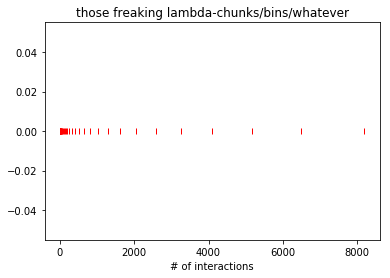

In [71]:
# for large genomes- calculate histograms i.e. start with lambda-chunking right away:

nlchunks = dotfinder.HiCCUPS_W1_MAX_INDX
base = 2 ** (1/3)
ledges = np.concatenate((
    [-np.inf],
    np.logspace(0, nlchunks - 1, num=nlchunks, base=base, dtype=np.float),
    [np.inf]))

#################################################
plt.plot(ledges,np.zeros_like(ledges),'r|')
plt.title("those freaking lambda-chunks/bins/whatever")
plt.xlabel("# of interactions")

In [51]:
gw_hist = dotfinder.scoring_and_histogramming_step(clr,
                                        expected,
                                        expected_name,
                                        balancing_weight_name,
                                        tiles,
                                        kernels,
                                        ledges,
                                        max_nans_tolerated,
                                        loci_separation_bins,
                                        nproc,
                                        verbose)


Preparing to convolve 49 tiles:
creating a Pool of 8 workers to tackle 49 tiles


### determine thresholds using the fdr thing ...

In [ ]:
##### to be continued ...

In [52]:
threshold_df, qvalues = dotfinder.determine_thresholds(
    kernels, ledges, gw_hist, 0.99)

### oveview of the 2D histogram 

x-bins corresponding to the $\lambda$-chunks and y-bins correspodning to the observed counts ...

/home/venevs/miniconda3/envs/dots-stable/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0, 'lambda-chunks')

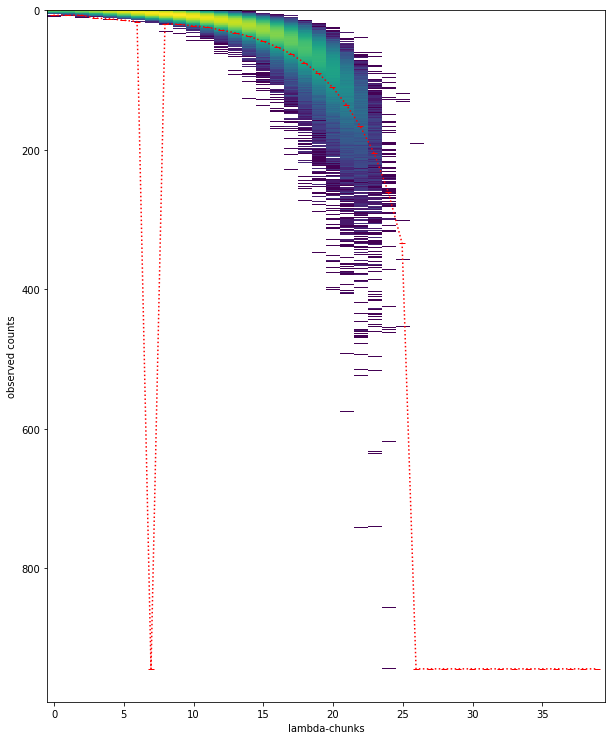

In [53]:
fig = plt.gcf()
fig.set_size_inches(10,30)
plt.imshow(np.log(gw_hist["donut"]),aspect=0.05)
ax = plt.gca()
ax.plot(np.arange(threshold_df["donut"].values.size)-0.05,threshold_df["donut"].values,color='r',marker="_",linestyle=":")

ax.set_ylabel("observed counts")
ax.set_xlabel("lambda-chunks")

### a histogram for a particular $\lambda$-chunk

5962


<BarContainer object of 1 artists>

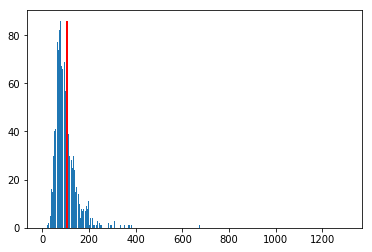

In [20]:
binid = 20
print(gw_hist["donut"].iloc[:,binid].values.sum())
hs = np.clip(gw_hist["donut"].iloc[:,binid].values,a_min=None,a_max=10000)
# hs = np.log(gw_hist["donut"].iloc[:,binid].values)
plt.bar(gw_hist["donut"].iloc[:,binid].index,hs)
plt.bar(threshold_df["donut"].iloc[binid],hs.max(),width=10,color='red')
# plt.gca().set_ylim(0,1)
# plt.gca().set_xlim(0,60)
# gw_hist["donut"].iloc[:,20]

### now extract "significant" pixels using the defined thresholds_df and the same parquet file with the score dump as for the histogramming step

In [33]:
filtered_pixels = dotfinder.extraction_step(tmp_scores,
                                            score_dump_mode,
                                            kernels,
                                            ledges,
                                            threshold_df,
                                            nproc=1,
                                            output_path=output_scores,
                                            verbose=False)

print("Number of filtered pixels {}".format(len(filtered_pixels)))

parquet input ...
Number of filtered pixels 21545


### annotate filtered pixeles and cluster them -> get centroids after that to proceed with post-processing ...

In [40]:
filtered_pixels_qvals = dotfinder.annotate_pixels_with_qvalues(filtered_pixels,
                                                                qvalues,
                                                                kernels)

In [42]:
filtered_pixels_annotated = cooler.annotate(filtered_pixels_qvals, clr.bins()[:])
centroids = dotfinder.clustering_step(
                            filtered_pixels_annotated,
                            expected_chroms,
                            dots_clustering_radius,
                            verbose)
print("Number of clustered pixels, i.e. centroids {}".format(len(centroids)))

/home/venevs/miniconda3/envs/dots-latest/lib/python3.6/site-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  node1_dist, node2_dist = dist[[farthest_idx]]


Clustering is completed:
6296 clusters detected
3.42+/-3.53 mean size

Clustering is over!
Number of clustered pixels, i.e. centroids 6296


In [45]:
final_out = dotfinder.thresholding_step(centroids)

In [46]:
len(final_out)

2327

## stuff that require clean up, but might be usefull in general 

/home/venevs/miniconda3/envs/dots-stable/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


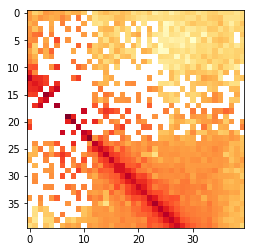

In [21]:
# plt.imshow(np.log(clr.matrix()[18030:18100,18030:18100]),cmap='YlOrRd')
# plt.scatter(53,18,s=80, facecolors='none', edgecolors='b')

bin1,bin2 = 18030+18,18030+53

bin1_n,bin2_n = 18030+23,18030+49


bin1,bin2 = 24322, 24334

plt.imshow(np.log(clr.matrix(balance=True)[bin1-20:bin1+20,bin2-20:bin2+20]),cmap='YlOrRd')

# something to have in mind - is the difference between JUicer balancing and cooler balacning ...
# MAD max filtering in particular
# in Juicer some of thesparse/low coverage regions are kept - what re the effects on the distriubtions, etc
# to be seen
# here is the region for reference: chr1:242,019,651-244,387,558 & chr1:242,713,339-243,695,154 [offset 0,0:0,0]

dddd = cccc[(cccc['bin1_id']==bin1)&(cccc['bin2_id']==bin2)]
eeee = cccc[(cccc['bin1_id']==bin1_n)&(cccc['bin2_id']==bin2_n)]

(cccc['bin2_id']-cccc['bin1_id']).min()